# Spacecraft attitude dynamics
<center> <img width="700" src="SolarSwingBy.gif"/>

In [1]:
import math, time
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from IPython.display import display, Math

from plotly.graph_objs import FigureWidget
import plotly.offline as py
import plotly.graph_objs as go

In [2]:
# constants and parameters
GOLDEN_RATIO = (math.sqrt(5) + 1)/2

R_CRAFT = 0.25
H_CRAFT = 0.35
E_CRAFT = (0,0,1)
M_CRAFT = 100
JZZ = M_CRAFT*R_CRAFT**2
JXX = JYY = M_CRAFT*(R_CRAFT**2/2 + H_CRAFT**2/12)
L_BOOM = 1.2
R_BOOM = 0.05
M_BOOM = 2700*4/3*math.pi*R_BOOM**3 # aluminum
JZZ_BOOM = 2*M_BOOM*R_BOOM**2/5
JXX_BOOM = JYY_BOOM = JZZ_BOOM + M_BOOM*(L_BOOM + H_CRAFT/2)**2

JXX += JXX_BOOM
JYY += JYY_BOOM
JZZ += JZZ_BOOM

MU = 3.986004e14

N=2*math.pi/(60*93)
R=(MU/N*N)**(1/3)

display(Math(r'J_1 = {} kg.m^2'.format(JXX)))
display(Math(r'J_2 = {} kg.m^2'.format(JYY)))
display(Math(r'J_3 = {} kg.m^2'.format(JZZ)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Stability map
<center> <img src="stability.pdf" width=450/>
<center> Green: stable. Light-grey: pitch unstable. Grey: yaw/roll unstable. Black: pitch/yaw/roll unstable.

In [3]:
# stability conditions
k1 = (JYY - JZZ)/JXX
k3 = (JYY - JXX)/JZZ
display(Math(r'k_1 = {}'.format(k1)))
display(Math(r'k_3 = {}'.format(k3)))

display(Math(r'\text{{Pitch: }} J_1 > J_3: {}'.format(JXX>JZZ)))
display(Math(r'\text{{Yaw/roll: }} k_1k_3 > 0: {}'.format(k1*k3>0)))
display(Math(r'\text{{Yaw/roll: }} 1 + 3k_1 + k_1k_3 > 0: {}'.format(1 + 3*k1 + k1*k3 > 0)))
display(Math(r'\text{{Yaw/roll: }} \left(1 + 3k_1 + k_1k_3\right)^2 - 16k_1k_3 > 0: {}'.format((1 + 3*k1 + k1*k3) > 16*k1*k3)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# gravity gradient rotational dynamics of a rigid spacecraft
# Euler angles: 3-2-1
def f(t, x):
    assert len(x) == 6, 'Error: length of x is {}, but should be 6'.format(len(x))
    
    ϕ = x[0]
    θ = x[1]
    ψ = x[2]
    
    p = x[3]
    q = x[4]
    r = x[5]
    
    cϕ = math.cos(ϕ)
    sϕ = math.sin(ϕ)
    cθ = math.cos(θ)
    sθ = math.sin(θ)
    cψ = math.cos(ψ)
    sψ = math.sin(ψ)
    
    kX = (JYY - JZZ)/JXX
    kY = (JZZ - JXX)/JYY
    kZ = (JXX - JYY)/JZZ
    
    c13 = -sθ
    c23 = sϕ*cθ
    c33 = cϕ*cθ
    
    p_dot = kX*q*r - 3*N*N*kX*c23*c33
    q_dot = kY*r*p - 3*N*N*kY*c33*c13
    r_dot = kZ*p*q - 3*N*N*kZ*c13*c23
    
    ϕ_dot = p + (sϕ*sθ*q + cϕ*sθ*r)/cθ + N*sψ/cθ
    θ_dot = (cϕ*cθ*q - sϕ*cθ*r)/cθ + N*cψ
    ψ_dot = (sϕ*q + cϕ*r)/cθ + N*sθ*sψ/cθ
    
    return np.array([ϕ_dot, θ_dot, ψ_dot, p_dot, q_dot, r_dot])

In [5]:
start_time = 0.0
orbit_period = 2*math.pi/N
stop_time = 2*orbit_period
number_of_frames = 500
eval_times = np.linspace(start_time, stop_time, number_of_frames)

ϵ = 1e-4
x0 = np.array([0., 0. , 0. , ϵ, -N, 0.])

sol = solve_ivp(f, (start_time, stop_time), x0, method='RK45', t_eval=eval_times)

In [6]:
def angle(θ):
    zero_360 = θ*180/math.pi % 360
    zero_360[zero_360 > 180] -= 360
    return zero_360


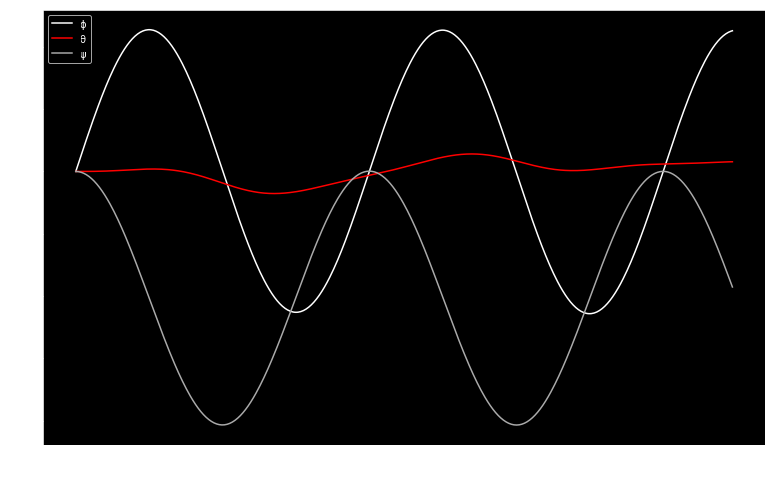

In [7]:
figure_size = (GOLDEN_RATIO*8, 8)
plt.figure(figsize=figure_size)
plt.style.use('dark_background')
plt.plot(sol.t, angle(sol.y[0]), 'w', label='ϕ')
plt.plot(sol.t, angle(sol.y[1]), 'r', label='θ')
plt.plot(sol.t, angle(sol.y[2]), '#AAAAAA', label='ψ')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('attitude [degree]')
plt.show()

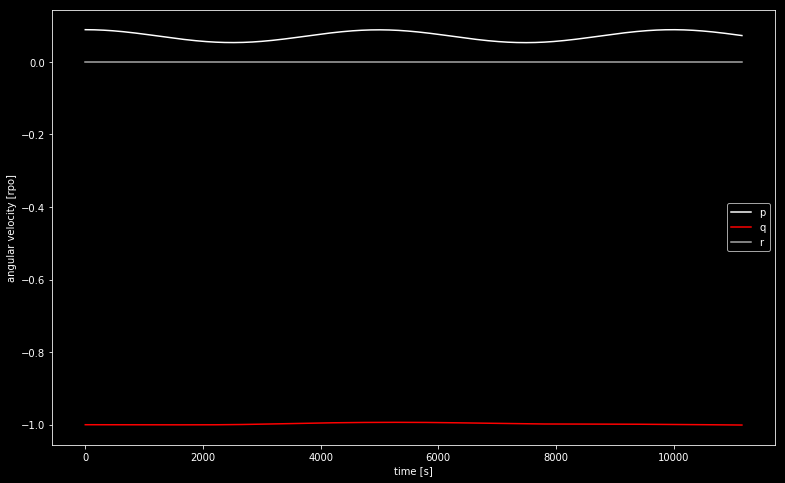

In [8]:
to_rpm = 60/2/math.pi
to_rpo = 1/N
plt.figure(figsize=figure_size)
plt.style.use('dark_background')
plt.plot(sol.t, sol.y[3]*to_rpo, 'w', label='p')
plt.plot(sol.t, sol.y[4]*to_rpo, 'r', label='q')
plt.plot(sol.t, sol.y[5]*to_rpo, '#AAAAAA', label='r')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rpo]')
plt.show()

In [9]:
def rotation_matrix(ϕ, θ, ψ):
    cϕ = math.cos(ϕ)
    sϕ = math.sin(ϕ)
    cθ = math.cos(θ)
    sθ = math.sin(θ)
    cψ = math.cos(ψ)
    sψ = math.sin(ψ)

    return np.array([[cθ*cψ, sϕ*sθ*cψ - cϕ*sψ, cϕ*sθ*cψ + sϕ*sψ],
                     [cθ*sψ, sϕ*sθ*sψ + cϕ*cψ, cϕ*sθ*sψ - sϕ*cψ],
                     [-sθ, sϕ*cθ, cϕ*cθ]])

def generate_sphere(radius, center, num=20):
    u1 = np.linspace(0, 2 * np.pi, num)
    v1 = u1.copy()
    uu, vv = np.meshgrid(u1, v1)

    x_center, y_center, z_center = center

    xx = x_center + radius * np.cos(uu) * np.sin(vv)
    yy = y_center + radius * np.sin(uu) * np.sin(vv)
    zz = z_center + radius * np.cos(vv)

    return xx, yy, zz

def generate_cylinder(r, h, e, center=(0,0,0), attitude=(0,0,0), numT=9, numZ=2):
    tol = 1e-6
    assert np.linalg.norm(e) > tol, 'Error: degenerate generatrix direction e = {}'.format(e)
    
    u1 = np.linspace(0, 2 * math.pi, numT)
    v1 = np.linspace(0, h, numZ)
    uu, vv = np.meshgrid(u1, v1)

    x_center, y_center, z_center = center 
    
    e /= np.linalg.norm(e)
    if np.linalg.norm([e[0], e[1]]) > tol:
        a = np.array([-e[1], e[0], e[2]])
    else:
        a = np.array([1,0,0])
    
    n = np.cross(a,e)
    n /= np.linalg.norm(n)    

    xyz = np.array([r*math.cos(u)*n + r*math.sin(u)*np.cross(e, n) + (v - h/2)*e
                    for u_row, v_row in zip(uu,vv)
                    for u,v in zip(u_row, v_row)])
    
    xyz = np.array([rotation_matrix(*attitude).dot(np.array([x,y,z]))
                    for x,y,z in xyz])
    
    xx = xyz[:,0].reshape(numT,numZ)
    yy = xyz[:,1].reshape(numT,numZ)
    zz = xyz[:,2].reshape(numT,numZ)
    
    xx += x_center
    yy += y_center
    zz += z_center

    return xx, yy, zz

def draw_craft(cylinder, boom, attitude):
    craft = []
    
    # body data
    r, h, e, center_of_mass = cylinder
    # boom data
    r_sphere, center_of_sphere = boom
    rotated_center = rotation_matrix(*attitude).dot(np.asarray(center_of_mass) + np.asarray(center_of_sphere))
    
    # tube
    tube = go.Scatter3d(
        x = np.array([center_of_mass[0], rotated_center[0]]),
        y = np.array([center_of_mass[1], rotated_center[1]]),
        z = np.array([center_of_mass[2], rotated_center[2]]),
        mode = 'lines',
        line = dict(
            color = colors['boom']
        ),
        name = None,
        showlegend=False
    )
    craft.append(tube)
    
    # sphere
    xx, yy, zz = generate_sphere(r_sphere, rotated_center)
    boom = go.Mesh3d({
                'x': xx.flatten(), 
                'y': yy.flatten(),
                'z': zz.flatten(), 
                'name': 'craft',
                'alphahull': 0,
                'color': colors['boom']
    })
    craft.append(boom)
    
    # main body
    xx, yy, zz = generate_cylinder(r, h, e, center=center_of_mass, attitude=(ϕ,θ,ψ))
    cylinder = go.Mesh3d({
                'x': xx.flatten(), 
                'y': yy.flatten(),
                'z': zz.flatten(), 
                'name': 'craft',
                'alphahull': 0,
                'color': colors['craft']
    })
    craft.append(cylinder)
    
    return craft

In [10]:
colors = dict()
colors["boom"] = "#888888"
colors["craft"] = "#888888"

font_color = '#AAAAAA'
axis_bg_color = "#101010"
grid_color = "#516883"

trace_earth = go.Scatter3d(
    x = np.array([0, 0]),
    y = np.array([0, 0]),
    z = np.array([0, H_CRAFT + R_CRAFT + L_BOOM]),
    mode = 'lines',
    name=None,
    showlegend=False
)

data = [trace_earth]*4

# configurations
frames = []
for ϕ,θ,ψ in zip(sol.y[0], sol.y[1], sol.y[2]):
    craft_k_frame = draw_craft((R_CRAFT, H_CRAFT, E_CRAFT,(0,0,0)), (R_BOOM,(0,0,-(H_CRAFT/2 + L_BOOM))), (ϕ,θ,ψ))
    frames.append(dict(data=craft_k_frame))

scene_range = [-(H_CRAFT/2 + R_CRAFT + L_BOOM), H_CRAFT + R_CRAFT + L_BOOM]
layout = go.Layout(
    paper_bgcolor='#000000',
    transition=dict(duration=0),
    font = dict(color=font_color),
    scene = dict(
                    xaxis = dict(
                         title='x [m]',
                         nticks=7,
                         range=scene_range,
                         backgroundcolor=axis_bg_color,
                         gridcolor=grid_color,
                         showbackground=True,
                         zerolinecolor=grid_color,),
                    yaxis = dict(
                        title='y [m]',
                        nticks=7,
                        range=scene_range,
                        backgroundcolor=axis_bg_color,
                        gridcolor=grid_color,
                        showbackground=True,
                        zerolinecolor=grid_color),
                    zaxis = dict(
                        title='z [m]',
                        nticks=7,
                        range=scene_range,
                        backgroundcolor=axis_bg_color,
                        gridcolor=grid_color,
                        showbackground=True,
                        zerolinecolor=grid_color,),
                    aspectratio = dict( x=1, y=1, z=1 ),
                    aspectmode = 'manual'
    ),
    title = "Spacecraft Attitude Dynamics",
    updatemenus=[{
                   'buttons': [
                       {'args': [None, {'frame': {'duration': 0, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 0}}],
                        'label': 'Play',
                        'method': 'animate'}
               ],
               'pad': {'r': 10, 't': 87},
               'showactive': False,
               'type': 'buttons'
                }]
)

fig = go.Figure(data=data, layout=layout, frames=frames)

py.plot(fig, filename='spacecraft-attitude-dynamics-animation.html')

'file:///Users/marcelo/Documents/UH/ME 360/Jupyter/lectures/ode/spacecraft-attitude-dynamics-animation.html'